In [90]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import sqlite3

In [91]:
# Getting all the words
df = pd.read_csv("/kaggle/input/financial-sentiment-analysis/data.csv")
words = {}

# Adding all words with only letters
for row in df["Sentence"]:
    valid = filter(lambda x: x.isalpha(), row.split())
    for word in valid:
        low = word.lower()
        if low not in words:
            words[low] = 0
        words[low] += 1

sorted_words = list(zip(list(words), list(words.values())))
sorted_words.sort(key=lambda x: -x[1])

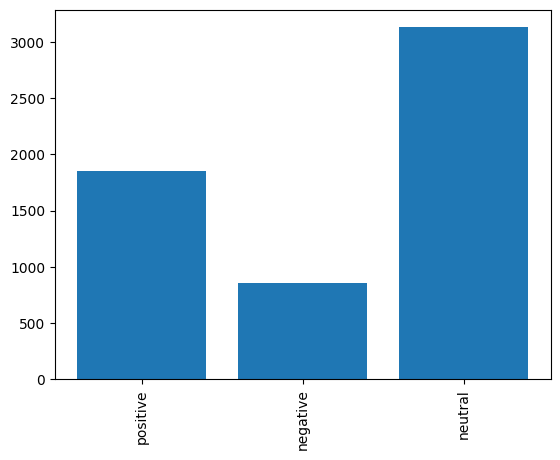

[('positive', 1852), ('negative', 860), ('neutral', 3130)]


In [92]:
# Label Analysis
labels = df.groupby("Sentiment").count()
class_labels = df["Sentiment"].unique()
class_counts = []
for label in class_labels:
    class_counts.append(labels.at[label, "Sentence"])

plt.bar(class_labels, class_counts)
plt.xticks(rotation="vertical")
plt.show()
print(list(zip(class_labels, class_counts)))

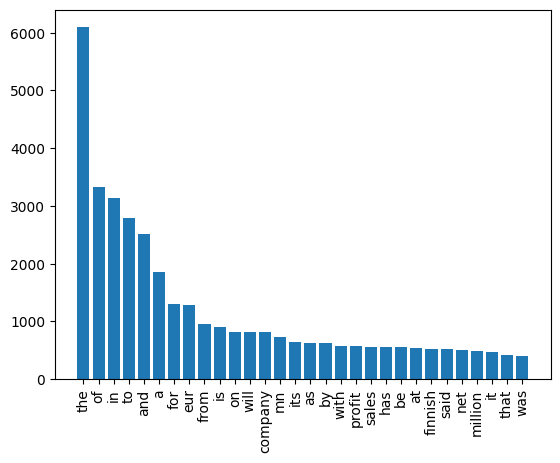

In [93]:
# Checking word frequency for top N words
N = 30
plt.bar([x[0] for x in sorted_words[:N]], [x[1] for x in sorted_words[:N]])
plt.xticks(rotation="vertical")
plt.show()

In [94]:
full_sum = sum([a[1] for a in sorted_words])

# The percentage of words I want to keep. This determines the dimension of the vector
keep = 0.7

total = 0
kept_words = []
for word, freq in sorted_words:
    total += freq
    kept_words.append((word, freq))

    if total / full_sum > keep:
        break

print(len(kept_words))

529


In [95]:
def one_hot(sentence, vocabulary):
    vectorizer = CountVectorizer(vocabulary=vocabulary)
    encoded_vector = vectorizer.transform([sentence]).toarray()[0]
    return encoded_vector

print(one_hot(df.at[0, "Sentence"].lower(), [a[0] for a in kept_words]))

[1 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [96]:
df["OneHot"] = df["Sentence"].apply(lambda x: one_hot(x.lower(), [a[0] for a in kept_words]))

y_class = ["negative", "neutral", "positive"]
df[y_class] = pd.get_dummies(df["Sentiment"], dtype=int)

X = df["OneHot"].tolist()
y = df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
log_fit = LogisticRegression(max_iter=100, class_weight={"negative": 0.3, "neutral": 0.55, "positive": 0.15}).fit(X_train, y_train)
svm_fit = LinearSVC(max_iter=100, class_weight={"negative": 0.3, "neutral": 0.55, "positive": 0.15}).fit(X_train, y_train)
print(log_fit.score(X_test, y_test))
print(svm_fit.score(X_test, y_test))

0.6359413202933986
0.637163814180929


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


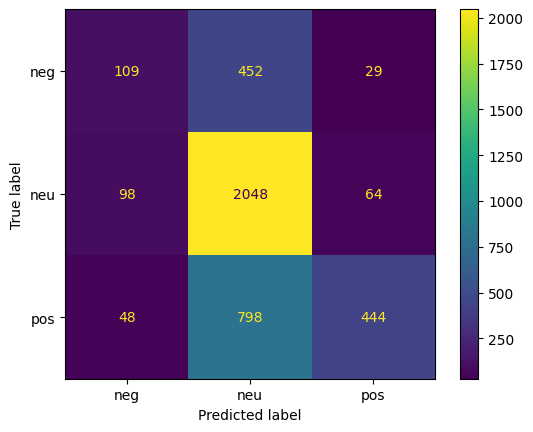

True Negative Rate: 0.1847457627118644
True Neutral Rate: 0.9266968325791856
True Positive Rate: 0.34418604651162793


In [97]:
y_pred_log = log_fit.predict(X_test)
log_cm = confusion_matrix(y_test, y_pred_log)
log_cm_display = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=["neg", "neu", "pos"])
log_cm_display.plot()
plt.show()

log_neg_rate = log_cm[0, 0] / log_cm[0, :].sum()
log_neu_rate = log_cm[1, 1] / log_cm[1, :].sum()
log_pos_rate = log_cm[2, 2] / log_cm[2, :].sum()
print(f"True Negative Rate: {log_neg_rate}\nTrue Neutral Rate: {log_neu_rate}\nTrue Positive Rate: {log_pos_rate}")

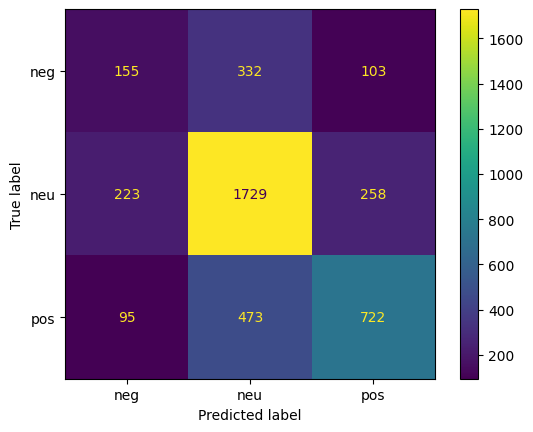

True Negative Rate: 0.2627118644067797
True Neutral Rate: 0.7823529411764706
True Positive Rate: 0.5596899224806201


In [98]:
y_pred_svm = svm_fit.predict(X_test)
svm_cm = confusion_matrix(y_test, y_pred_svm)
svm_cm_display = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=["neg", "neu", "pos"])
svm_cm_display.plot()
plt.show()

svm_neg_rate = svm_cm[0, 0] / svm_cm[0, :].sum()
svm_neu_rate = svm_cm[1, 1] / svm_cm[1, :].sum()
svm_pos_rate = svm_cm[2, 2] / svm_cm[2, :].sum()
print(f"True Negative Rate: {svm_neg_rate}\nTrue Neutral Rate: {svm_neu_rate}\nTrue Positive Rate: {svm_pos_rate}")

In [99]:
samples = [
    "The company increased in value",
    "The company decreased in value",
]
samples = list(map(lambda x: one_hot(x, [a[0] for a in kept_words]), samples))
print(log_fit.predict(np.array(samples)))
print(svm_fit.predict(np.array(samples)))

['neutral' 'neutral']
['positive' 'neutral']


In [100]:
print(f"LR Score:\n\t {f1_score(y_pred_log, y_test, average='weighted')}\n")
print(f"SVM Score:\n\t {f1_score(y_pred_svm, y_test, average='weighted')}")

LR Score:
	 0.6795440386878823

SVM Score:
	 0.6464655052759115


In [101]:
df["log_pred"] = log_fit.predict(df["OneHot"].tolist())
df["svm_pred"] = svm_fit.predict(df["OneHot"].tolist())
df[:10]

,Sentence,Sentiment,OneHot,negative,neutral,positive,log_pred,svm_pred
0,The GeoSolutions technology will leverage Bene...,positive,"[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0,0,1,positive,negative
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1,0,0,negative,negative
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, ...",0,0,1,neutral,neutral
3,According to the Finnish-Russian Chamber of Co...,neutral,"[2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,0,neutral,neutral
4,The Swedish buyout firm has sold its remaining...,neutral,"[2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",0,1,0,neutral,neutral
5,$SPY wouldn't be surprised to see a green close,positive,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,1,neutral,neutral
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,neutral,neutral
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative,"[2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, ...",1,0,0,positive,positive
8,Kone 's net sales rose by some 14 % year-on-ye...,positive,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,1,positive,positive
9,The Stockmann department store will have a tot...,neutral,"[2, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, ...",0,1,0,neutral,neutral


In [102]:
!rm -rf /kaggle/working/*
connection = sqlite3.connect("financial_sentiment.db")
cursor = connection.cursor()
cursor.execute("CREATE TABLE finance (Sentence TEXT, Sentiment TEXT, log_pred TEXT, svm_pred TEXT)")

df_labels = ["Sentence", "Sentiment", "log_pred", "svm_pred"]
df[df_labels].to_sql('finance', connection, if_exists='replace', index=False)
rows = cursor.execute("SELECT Sentiment, log_pred, svm_pred FROM finance").fetchall()
print(rows[:10])

[('positive', 'positive', 'negative'), ('negative', 'negative', 'negative'), ('positive', 'neutral', 'neutral'), ('neutral', 'neutral', 'neutral'), ('neutral', 'neutral', 'neutral'), ('positive', 'neutral', 'neutral'), ('negative', 'neutral', 'neutral'), ('negative', 'positive', 'positive'), ('positive', 'positive', 'positive'), ('neutral', 'neutral', 'neutral')]


In [103]:
!pip freeze > requirements.txt